# Beta Shrinkage

In [110]:
%%capture
%load_ext autoreload
%autoreload 2

import numpy as np
import yfinance as yf
import pandas as pd
import bs4 as bs
import requests
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from tqdm import tqdm

from src.beta import Beta, BetaBMA, BetaForecastCombination
from src.utils import stack_dict_to_df

## Single Stock Example

The first case is simply to show the beta between a stock, `AAPL`, and an index, `SPY`. This is done
over a month, i.e. we take 21 observations and then forecast the beta for the coming month. This
beta could e.g. be used as a hedge ratio. Say you want to hedge your market exposure and buy 100
stocks of Apple. If the Apple stock price is currently at 150 USD you will need to sell $100 \times 150 \times \beta$
USD of the index (could be futures or ETF).


In [3]:
# pull sample data and aggregate returns
start_date = "2017-01-01"
end_date = "2022-01-01"

sample_data = yf.download("AAPL SPY", start=start_date, end=end_date, progress=False)["Adj Close"]
sample_returns = sample_data.pct_change().dropna()
sample_returns.index = pd.DatetimeIndex(sample_returns.index)

# calculate betas
bivar_beta = Beta(sample_returns["SPY"].iloc[-21:], sample_returns["AAPL"].iloc[-21:])
benchmark = sample_returns.cov().iloc[0,1] / sample_returns["SPY"].var()
ols_classic = bivar_beta.ols(False)
ols_adj = bivar_beta.ols(True)
ewma = bivar_beta.ewma()
vasicek = bivar_beta.vasicek()
welch_classic = bivar_beta.welch()
welch_aged = bivar_beta.welch(rho=2/256)
robeco = bivar_beta.robeco(0.5, 2)
scholes_williams = bivar_beta.scholes_williams()
fc_comb = BetaForecastCombination(sample_returns["SPY"], sample_returns["AAPL"]).fit()
bma = BetaBMA(sample_returns["SPY"], sample_returns["AAPL"]).fit()

report = """
    Beta Calculation Methods
    ------------------------
    Benchmark: {:.4f}
    Classic OLS: {:.4f}
    Adjusted OLS: {:.4f}
    EWMA: {:.4f}
    Vasicek: {:.4f}
    Welch: {:.4f}
    Welch (aged): {:.4f}
    Robeco: {:.4f}
    Scholes-Williams: {:.4f}
    Forecast Combination: {:.4f}
    Bayesian Model Averaging: {:.4f}
    
""".format(benchmark, ols_classic, ols_adj, ewma, vasicek, welch_classic, welch_aged, robeco, scholes_williams, fc_comb, bma)
print(report)


    Beta Calculation Methods
    ------------------------
    Benchmark: 1.2309
    Classic OLS: 1.4425
    Adjusted OLS: 1.2965
    EWMA: 1.4896
    Vasicek: 1.3571
    Welch: 1.4181
    Welch (aged): 1.4240
    Robeco: 1.1965
    Scholes-Williams: 1.4333
    Forecast Combination: 1.4450
    Bayesian Model Averaging: 1.4336
    



## Cross-Sectional Analysis

Next we run the same analysis for the entire SPX. To get the index members we can query Wikipedia and then parse the symbols. Note that this is only a snapshot of the current constituents and wouldn't work in any point-in-time setting. Getting real point-in-time data is not a trivial thing to do and is most likely only available commercially.

We'll visualise the autocorrelation of monthly index betas (using standard OLS equation) by using Kendall's $\tau$. The statistic is bounded in $[-1,1]$ and its interpretation is similar to Spearman's (or Pearson's) but is more robust to outliers. Kendall's $\tau$ gives us a measure of rank correlation and tells us about the persistence of beta (i.e. is the previous month beta indicative for the next month). The answer is unfortunately not very clear, but at least there's no negative relationship. 

Next we run the beta for all stocks on a monthly basis in an attempt to forecast the next month. For all models except for Forecast Combination and BMA we use 21 observations. For those two models we use 3 years of history. We drop stocks that have fewer than 10 observations.

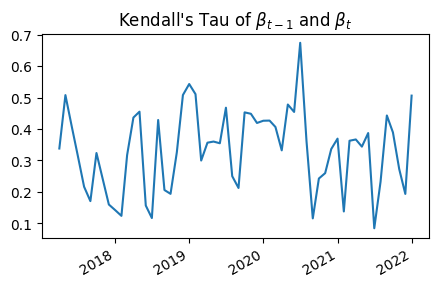

In [4]:
# scrape index constituents using beautifulsoup4 (remove some exceptions below)
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = [row.findAll('td')[0].text for row in table.findAll('tr')[1:]]
tickers = [s.replace('\n', '') for s in tickers] + ["SPY"]
[tickers.remove(i) for i in ["CEG", "BF.B", "BRK.B"]]

# get data via yahoo finance and calculate daily returns
data = yf.download(tickers, start=start_date, end=end_date, progress=False, debug=False)["Adj Close"]
member_returns = data.pct_change().iloc[1:,:].dropna(axis=1)
member_returns.index = pd.DatetimeIndex(member_returns.index)
member_returns.index.name = ""

# calculate rolling 1 month beta using textbook definition: corr * vol ratio
corr = member_returns.groupby(pd.Grouper(freq="M")).apply(lambda x: x.corr().loc["SPY",:]).iloc[1:,:]
std_i = member_returns.groupby(pd.Grouper(freq="M")).std().iloc[1:]
std_bm = member_returns[["SPY"]].groupby(pd.Grouper(freq="M")).std().iloc[1:]
index_beta = corr * (std_i.values / std_bm.values)
index_beta.dropna(inplace=True)

# visualise correlation between beta
corr = [scipy.stats.kendalltau(index_beta.iloc[i-1,:], index_beta.iloc[i,:])[0] for i in range(1, index_beta.shape[0])]
pd.DataFrame(corr, index=index_beta.index[1:]).plot(figsize=(5,3), legend=False, title=r"Kendall's Tau of $\beta_{t-1}$ and $\beta_t$");

In [61]:
results = {}
window = 3
offset = pd.offsets.YearBegin(window)
offset_start = pd.Timestamp(start_date) + offset

for stock in tqdm(member_returns.drop(columns=["SPY"]).columns):
    returns = member_returns[member_returns.index >=  offset_start].loc[:, [stock, "SPY"]]
    results[stock] = {}
    for block in returns.groupby(pd.Grouper(freq="M")):
        # for "simpler" betas the monthly observations suffice
        # for forecast combinations we need more history, here we use 3 years
        date, df = block
        fc_df = returns[(returns.index >= (date - offset)) & (returns.index <= date)]
        
        # set some arbitrary data size threshold ()
        if df.shape[0] > 10 and fc_df.shape[0] > 252:
            exog, endog = df["SPY"], df[stock]
            stock_beta = Beta(exog, endog)
            results[stock][date] = {
                "ols": stock_beta.ols(False),
                "ols_adj": stock_beta.ols(True),
                "vasicek": stock_beta.vasicek(),
                "welch": stock_beta.welch(),
                "welch_aged": stock_beta.welch(rho=2/256),
                "robeco": stock_beta.robeco(0.5, 1.2),
                "scholes_williams": stock_beta.scholes_williams(),
                "forecast_comb": BetaForecastCombination(fc_df["SPY"], fc_df[stock]).fit(),
                "bayesian_ma": BetaBMA(fc_df["SPY"], fc_df[stock]).fit()
            }
     
beta_results = stack_dict_to_df(results)

100%|██████████| 488/488 [49:56<00:00,  6.14s/it]


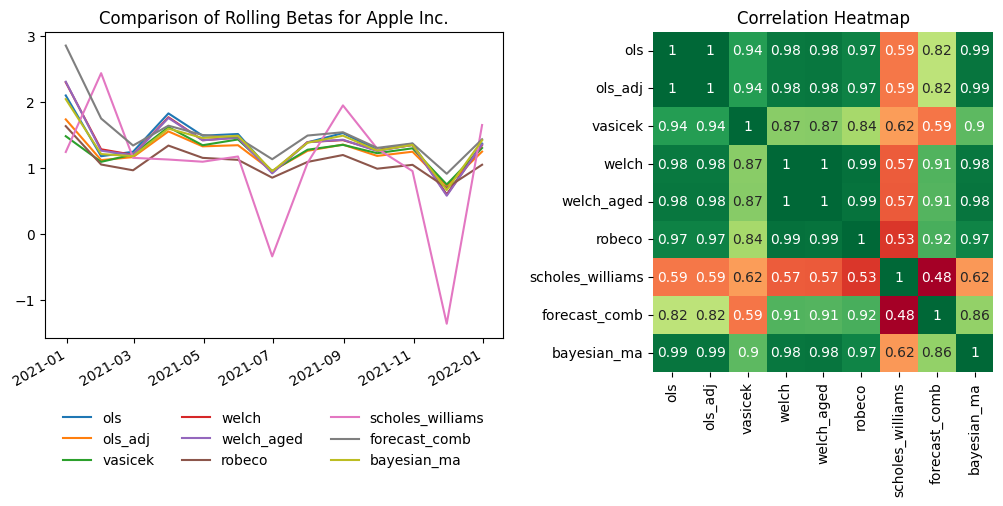

In [6]:
data = beta_results["AAPL"].rename(columns={"forecast_combination": "forecast_comb"})

fig, ax = plt.subplots(ncols=2, figsize=(13,5))
data.plot(title="Comparison of Rolling Betas for Apple Inc.", ax=ax[0])
box = ax[0].get_position()
ax[0].set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, frameon=False)
sns.heatmap(data.corr(), cmap='RdYlGn', ax=ax[1], annot=True, cbar=False, square=True)
ax[1].set_title("Correlation Heatmap");

## Performance

We use the RMSE as a mean to compare the performance of individual beta estimators to the next month realised beta.

From this small study it appears that on a median basis, the Robeco and Vasicek model have fared the best. As was already obvious from the Apple example, the results for Scholes-Williams are pretty terrible. Possibly an implementation error from my side? In terms of the more complex models, BMA fares better than Forecast Combination. Interesting enough, the simple adjusted OLS model actually gives fairly decent results.

Do note however that this is a *small* subset of data history available. Since the computational effort is quite large for BMA (actually we run $2^k$ model combinations), I've kept it to a short time history.

In [9]:
rms_errors = {}

for stock in results:
    rms_errors[stock] = {}
    beta_lag = beta_results[stock].shift(1).dropna()
    beta_lead = index_beta[[stock]]
    
    for model in beta_lag.columns:
        rmse = np.sqrt(np.square(beta_lag[[model]].join(beta_lead).diff(axis=1).iloc[:,-1]).mean())
        rms_errors[stock][model] = rmse
        
rmse_df = pd.DataFrame.from_dict(rms_errors).T
rmse_df.describe().iloc[1:,:].round(2)

,ols,ols_adj,vasicek,welch,welch_aged,robeco,scholes_williams,forecast_combination,bayesian_ma
mean,0.63,0.55,0.54,0.58,0.58,0.53,1.72,0.67,0.58
std,0.27,0.22,0.21,0.22,0.22,0.21,0.99,0.34,0.23
min,0.18,0.16,0.16,0.20,0.20,0.17,0.40,0.18,0.17
25%,0.44,0.39,0.40,0.43,0.43,0.39,1.00,0.46,0.42
50%,0.58,0.51,0.50,0.55,0.54,0.49,1.43,0.60,0.54
75%,0.75,0.65,0.62,0.68,0.69,0.62,2.14,0.81,0.68
max,2.25,1.94,1.67,1.80,1.80,1.77,6.23,2.92,2.17


## Hedging

Another way to assess the performance of our pool of beta estimators is to calculate beta hedged portfolios. For each stock we calculate the returns $r_{bh}=r_i - \beta_k r_m$ and then analyse the overall market exposure. If an estimator is good, the overall market exposure from one period to the next should be very low (ideally close to zero).

In [87]:
# do some pandas acrobatics to get the data in the right shape
filtered_returns = member_returns[beta_results.columns.get_level_values(0).unique()]
repeated_returns = pd.concat([filtered_returns] * rmse_df.shape[1], axis=1).sort_index(axis=1).T
repeated_returns.index.name = "stock"
repeated_returns["metric"] = np.tile(rmse_df.columns, filtered_returns.shape[1])
repeated_returns = repeated_returns.reset_index().set_index(["stock","metric"]).T
repeated_returns.index = pd.to_datetime(repeated_returns.index)
daily_beta = beta_results.reindex(repeated_returns.index).ffill()
market_returns = member_returns[["SPY"]].values

# calculate hedged portfolios
hedged_portfolios = repeated_returns - daily_beta * market_returns
hedged_portfolios.dropna(inplace=True)

In [187]:
hedge_results = {}
for stock in member_returns.drop(columns=["SPY"]).columns:
    hedge_results[stock] = {}
    for beta in rmse_df.columns:
        one = np.ones((hedged_portfolios.shape[0], 1))
        X = np.hstack([one, member_returns.loc[hedged_portfolios.index, ["SPY"]]])
        y = hedged_portfolios.loc[:, (stock, beta)] 
        b = np.linalg.pinv(X) @ y
        rho = b[1] * np.std(X[:,1]) / np.std(y)
        hedge_results[stock][beta] = {
            "b": b[1],
            "rho": rho,
            "r_squared": rho**2
        }

hedge_df = pd.concat({k: pd.DataFrame(v) for k, v in hedge_results.items()})

Using $R^2$ as our measure of choice, we see that on average the market exposure is zero across the board. The $R^2$ gives us the variance explained by the market factor, i.e. our $X$ variable, in the regression. Some beta measures have much wider tails than others. For example, Scholes Williams does a much worse job than Forecast Combination or even Adjusted OLS.

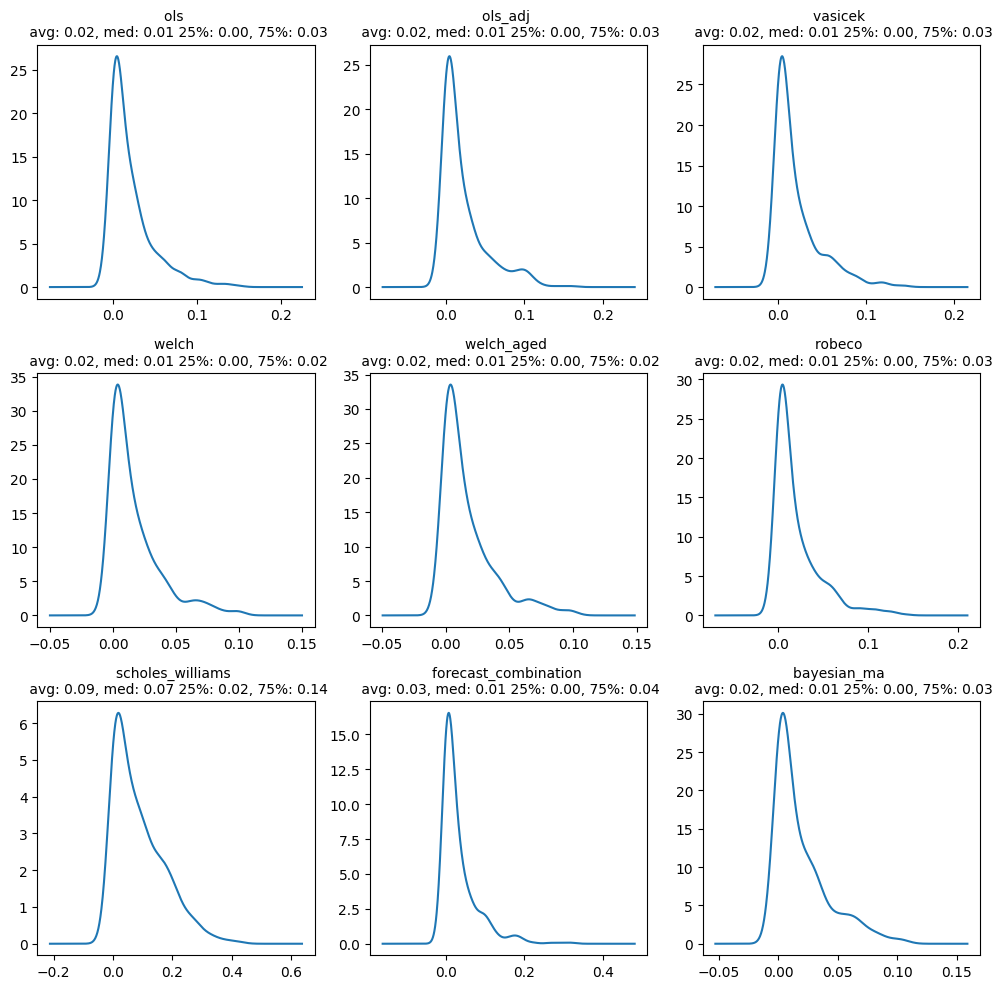

In [241]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(10,10))
c = 0
for i in range(3):
    for j in range(3):
        metric = rmse_df.columns[c]
        data = hedge_df.unstack()[metric][["r_squared"]]
        title = "{} \n avg: {:.2f}, med: {:.2f} 25%: {:.2f}, 75%: {:.2f}".format(
            metric, data.mean()[0], data.median()[0], data.quantile(0.25)[0], data.quantile(0.75)[0]
        )
        data.plot(kind='density', ax=ax[i,j], title=title, legend=False)
        ax[i,j].title.set_size(10)
        ax[i,j].set_ylabel('')
        c += 1
fig.tight_layout()